# Recurrent Neural Network Assignment
## Gabriel Marcelino, Grant Burk, Eli   
## CST-435
**October 30, 2024**  


## Problem Statement
Goal is to develop a neural network model capable of predicting the next word in a sentence based on a given sequence of words. This model should use a recurrent neural network (RNN), specifically an LSTM architecture, to understand the sequential context of text data. By training on a large corpus of text, the model will be able to suggest the most likely word to follow a given input sequence.

## 1. Import Requirements and Load data


In [7]:
import kagglehub
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import random
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences


path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")
nltk.download('punkt_tab')

print("Path to dataset files:", path)

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Select a subset of files (e.g., first 10 files)
subset_files = files[:10]
print("Subset of files:", subset_files)

# Load and process the subset of files
# Load only the first 800,000 characters
data = ""
char_limit = 8000000
for file in subset_files:
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        data += f.read(char_limit - len(data))
        if len(data) >= char_limit:
            break


print("Loaded data from subset of files")


Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/mikeortman/wikipedia-sentences/versions/3
Files in dataset: ['wikisent2.txt']
Subset of files: ['wikisent2.txt']
Loaded data from subset of files


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gabriel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Visualize data

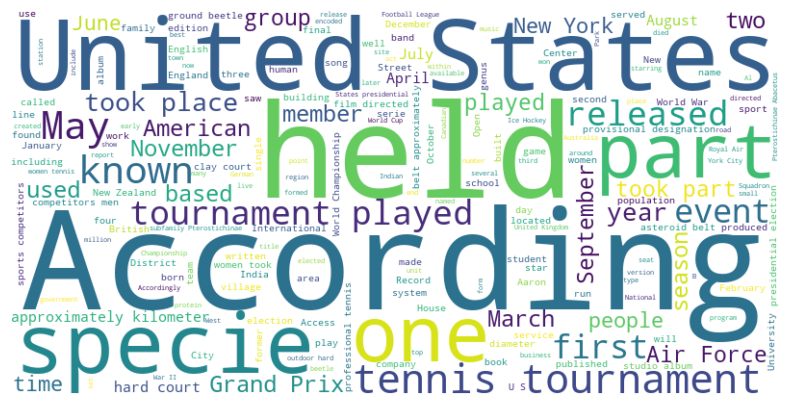

In [8]:
# Visualize data with a word cloud to see most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3. Prepare Data

In [9]:
# Print sample of raw data
print("Raw data sample:")
print(data[:1000])

# Step 1: Basic text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace multiple spaces with single space
    text = ' '.join(text.split())
    return text

data = clean_text(data)

# Step 2: Split into sentences
sentences = sent_tokenize(data)

def clean_sentence(sentence):
    # Check if the sentence contains digits
    if re.search(r'\d', sentence):
        return None
    # Modify the regex to keep more punctuation and structure
    sentence = re.sub(r'[^a-z\s.,!?\'"]', '', sentence)  # Remove special characters but keep punctuation
    # Remove extra whitespace
    sentence = ' '.join(sentence.split())
    # Minimum word requirement
    if len(sentence.split()) < 5:  
        return None
    return sentence

# Clean sentences and remove empty ones
sentences = [clean_sentence(sentence) for sentence in sentences]
sentences = [s for s in sentences if s is not None]

print("\nCleaned sentences sample:")
print(sentences[:10])

# Replace the existing tokenizer configuration with:
tokenizer = Tokenizer(
    num_words=20000,  # Limit the vocabulary size to 20,000 words
    oov_token="<OOV>",
    filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n',
    lower=True
)

# Fit the tokenizer on the texts
tokenizer.fit_on_texts(sentences)

# Update the vocab_size variable accordingly
vocab_size = min(len(tokenizer.word_index) + 1, 20000)  # Limit to 20,000 words

# Print vocabulary statistics
print("\nVocabulary statistics:")
print(f"Total unique words: {len(tokenizer.word_index)}")
print(f"Most common words: {list(tokenizer.word_index.items())[:10]}")

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

print("\nSequence samples:")
print(sequences[:10])


Raw data sample:
0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.
000webhost is a free web hosting service, operated by Hostinger.
0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.
0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.
0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.
001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.
003230 is a South Korean food manufacturer.
0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.
0.04% of the votes were invalid.
005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa.
005 is a 1981 arc

## 4. Create Features and Labels

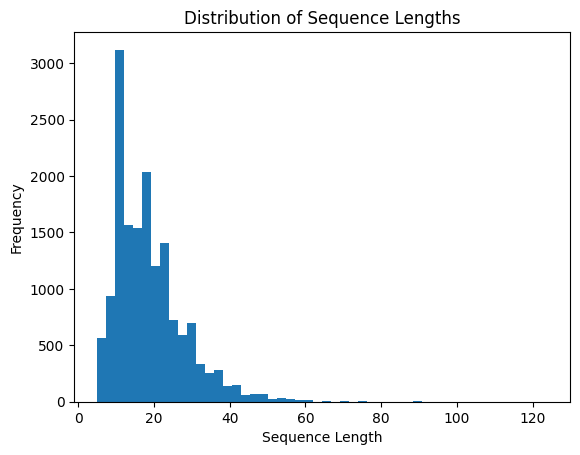

Adjusted max sequence length: 75
Shape of X after padding: (1173196, 74)
Shape of X_small: (40000, 74)
Shape of y_small before one-hot encoding: (40000,)
Final shapes:
X_train: (32000, 74)
X_test: (8000, 74)
y_train: (32000, 20000)
y_test: (8000, 20000)


In [10]:
if sequences:
    sequence_lengths = [len(seq) for seq in sequences]
    plt.hist(sequence_lengths, bins=50)
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Sequence Lengths')
    plt.show()

    # Set max length based on distribution and pad sequences
    max_sequence_len = min(max(sequence_lengths), 75)
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
    print(f"Adjusted max sequence length: {max_sequence_len}")

    X, y = [], []
    for sentence in padded_sequences:
        for i in range(1, len(sentence)):
            X.append(sentence[:i])
            y.append(sentence[i])

    # Pad input sequences to a consistent length
    X = pad_sequences(X, maxlen=max_sequence_len - 1, padding='post')
    print(f"Shape of X after padding: {X.shape}")
else:
    print("Warning: 'sequences' is empty. Check your input data.")

# Reduce dataset size
if len(X) > 0 and len(y) > 0:
    X = np.array(X)
    y = np.array(y)

    if X.shape[0] >= 40000:
        X_small = X[:40000].astype(np.int32)
        y_small = y[:40000]
        y_small = np.where(y_small >= vocab_size, 0, y_small)
        print(f"Shape of X_small: {X_small.shape}")
        print(f"Shape of y_small before one-hot encoding: {y_small.shape}")
    else:
        print("Warning: Dataset is smaller than 40,000 samples; skipping truncation.")

    # Chunking and Splitting
    chunk_size = 5000
    num_chunks = len(X_small) // chunk_size
    X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        X_chunk = X_small[start_idx:end_idx]
        y_chunk = y_small[start_idx:end_idx]

        if X_chunk.size and y_chunk.size:
            X_train_chunk, X_test_chunk, y_train_chunk, y_test_chunk = train_test_split(
                X_chunk, y_chunk, test_size=0.2, random_state=42 + i
            )
            X_train_list.append(X_train_chunk)
            X_test_list.append(X_test_chunk)
            y_train_list.append(y_train_chunk)
            y_test_list.append(y_test_chunk)

    if X_train_list and X_test_list and y_train_list and y_test_list:
        X_train = np.concatenate(X_train_list)
        X_test = np.concatenate(X_test_list)
        y_train = np.concatenate(y_train_list)
        y_test = np.concatenate(y_test_list)

        # Convert to one-hot encoding
        y_train = to_categorical(y_train, num_classes=vocab_size)
        y_test = to_categorical(y_test, num_classes=vocab_size)

        print("Final shapes:")
        print(f"X_train: {X_train.shape}")
        print(f"X_test: {X_test.shape}")
        print(f"y_train: {y_train.shape}")
        print(f"y_test: {y_test.shape}")
    else:
        print("Error: Lists are empty after chunking and splitting.")

    # Cleanup
    del X_train_list, X_test_list, y_train_list, y_test_list, X_small, y_small
else:
    print("Error: 'X' or 'y' is empty after padding. Check input data.")



## 5. Build Model

In [11]:

# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove.42B.300d.txt'
if not os.path.exists(glove_path):
    print(
        f"File {glove_path} not found. Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the current directory.")
else:
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    print(f"Loaded {len(embedding_index)} word vectors.")

# Create an embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with Bidirectional LSTM
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len - 1,
              trainable=False),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),  # Increased dropout rate
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define EarlyStopping and ModelCheckpoint  callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def predict_next_word(text, num_words=1, temperature=1.0):
    sequence = tokenizer.texts_to_sequences([text])[0]
    generated_text = []
    for _ in range(num_words):
        padded = pad_sequences([sequence], maxlen=max_sequence_len - 1, padding='pre')
        pred = model.predict(padded, verbose=0)[0]
        next_word_idx = sample_with_temperature(pred, temperature)

        if next_word_idx == 0:
            break

        next_word = tokenizer.index_word.get(next_word_idx, "")
        sequence.append(next_word_idx)
        generated_text.append(next_word)

        # Stop if a period is found
        if next_word == ".":
            break

    return " ".join(generated_text)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

# Testing the function
test_sentences = [
    "The ancient city of",
    "The protagonist of the story",
    "He was",
    "The weather was"
]
for test_sentence in test_sentences:
    completed_text = predict_next_word(test_sentence, num_words=10)
    print(f"Original: {test_sentence}")
    print(f"Completed: {test_sentence} {completed_text}")

# Enhanced Evaluation Function
def evaluate_model():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Run enhanced evaluation
evaluate_model()


Loaded 1917494 word vectors.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 105s 241ms/step - accuracy: 0.7802 - loss: 3.2606 - val_accuracy: 0.7761 - val_loss: 2.1654
Epoch 2/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 222ms/step - accuracy: 0.7979 - loss: 1.8113 - val_accuracy: 0.7761 - val_loss: 2.2501
Epoch 3/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 88s 219ms/step - accuracy: 0.7959 - loss: 1.6190 - val_accuracy: 0.7758 - val_loss: 2.4203
Epoch 4/20
400/400 ━━━━━━━━━━━━━━━━━━━━ 89s 221ms/step - accuracy: 0.8044 - loss: 1.4545 - val_accuracy: 0.7320 - val_loss: 2.4156
Original: The ancient city of
Completed: The ancient city of dugout
Original: The protagonist of the story
Completed: The protagonist of the story aalborg perhaps
Original: He was
Completed: He was 
Original: The weather was
Completed: The weather was is involutive.
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.7947 - loss: 1.9753

Test Loss: 2.0373
Test Accuracy: 0.7868


## Algorithm of the solution

## Analysis of the findings

## References
https://www.geeksforgeeks.org/next-word-prediction-with-deep-learning-in-nlp/